In [1]:
import time

t_debut = time.time()

import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score

from tools import datasets

Importation de la liste des variables explicatives sélectionnées et des meilleurs paramètres pour chaque modèle.

In [2]:
import json

# Régression logistique
with open('backups/RFECV_LR.json') as column_file:
    LR_COLUMNS = json.load(column_file)
    LR_COLUMNS_QUANT = LR_COLUMNS['columns_quant']
    LR_COLUMNS_CAT = LR_COLUMNS['columns_cat']
    LR_COLUMNS = LR_COLUMNS_QUANT + LR_COLUMNS_CAT

with open('backups/PARAMS_LR.json') as param_file:
    LR_PARAMS = json.load(param_file)

print(f'Variables explicatives régression logistique ({len(LR_COLUMNS)}) :')
display(LR_COLUMNS)

print(f'Meilleurs paramètres régression logistique ({len(LR_PARAMS)}) :')
display(LR_PARAMS)

# Forêts aléatoires
with open('backups/RFECV_Forest.json') as column_file:
    F_COLUMNS = json.load(column_file)
    F_COLUMNS_QUANT = F_COLUMNS['columns_quant']
    F_COLUMNS_CAT = F_COLUMNS['columns_cat']
    F_COLUMNS = F_COLUMNS_QUANT + F_COLUMNS_CAT

with open('backups/PARAMS_Forest.json') as param_file:
    F_PARAMS = json.load(param_file)

print(f'Variables explicatives forêts aléatoires ({len(F_COLUMNS)}) :')
display(F_COLUMNS)

print(f'Meilleurs paramètres forêts aléatoires ({len(F_PARAMS)}) :')
F_PARAMS['class_weight'] = {int(k): v for k,v in F_PARAMS['class_weight'].items()}
display(F_PARAMS)

# XGBoost
with open('backups/RFECV_XGBoost.json') as column_file:
    XG_COLUMNS = json.load(column_file)
    XG_COLUMNS_QUANT = XG_COLUMNS['columns_quant']
    XG_COLUMNS_CAT = XG_COLUMNS['columns_cat']
    XG_COLUMNS = XG_COLUMNS_QUANT + XG_COLUMNS_CAT

with open('backups/PARAMS_XGBoost.json') as param_file:
    XG_PARAMS = json.load(param_file)

print(f'Variables explicatives XGBoost ({len(XG_COLUMNS)}) :')
display(XG_COLUMNS)

print(f'Meilleurs paramètres XGBoost ({len(XG_PARAMS)}) :')
display(XG_PARAMS)

Variables explicatives régression logistique (11) :


['display_size',
 'nbdayssincelastclick',
 'campaignctrlast24h',
 'nbdisplay_1hour',
 'zonecostineuro',
 'device_type_Desktop',
 'display_env_app_ios',
 'campaignscenario_13',
 'device_type_iPhone',
 'target_env_2',
 'is_interstitial_True']

Meilleurs paramètres régression logistique (2) :


{'C': 52.98316906283702, 'class_weight': 'balanced'}

Variables explicatives forêts aléatoires (9) :


['display_size',
 'nbdayssincelastclick',
 'campaignctrlast24h',
 'nbdisplay_1hour',
 'dayssincelastvisitdouble',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'contextid',
 'zonecostineuro',
 'is_interstitial_True']

Meilleurs paramètres forêts aléatoires (7) :


{'n_estimators': 1500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 1, 1: 32},
 'bootstrap': True}

Variables explicatives XGBoost (8) :


['nbdayssincelastclick',
 'campaignctrlast24h',
 'nbdisplay_1hour',
 'contextid',
 'zonecostineuro',
 'is_interstitial_True',
 'device_type_iPad',
 'device_type_Desktop']

Meilleurs paramètres XGBoost (8) :


{'subsample': 0.6,
 'scale_pos_weight': 16.5,
 'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 1.0}

# Régression logistique

In [3]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
datasets_df = datasets(df, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, verbose=False)
X = datasets_df['X_scaled']
y = datasets_df['y']
X_train_LR, X_val_LR, y_train_LR, y_val_LR = train_test_split(X, y, train_size=0.80, random_state=1234)

In [4]:
%%time
clf = LogisticRegression(**LR_PARAMS)
clf.fit(X_train_LR, y_train_LR)

y_probas_LR = clf.predict_proba(X_val_LR)[:, 1]

CPU times: user 3.81 s, sys: 495 ms, total: 4.3 s
Wall time: 1.36 s


In [5]:
def f3_LR(seuil):
    y_pred = (y_probas_LR >= seuil) * 1
    precision = precision_score(y_val_LR, y_pred)
    recall = recall_score(y_val_LR, y_pred)
    f3 = (10 * precision * recall) / (9 * precision + recall)
    return f3

f3_LR_v = np.vectorize(f3_LR)

In [6]:
[s_opt_LR] = scipy.optimize.fmin(lambda s: - f3_LR(s), 0.5)
print(f"Meilleur seuil : {s_opt_LR}")

Optimization terminated successfully.
         Current function value: -0.480432
         Iterations: 11
         Function evaluations: 24
Meilleur seuil : 0.4556640624999999


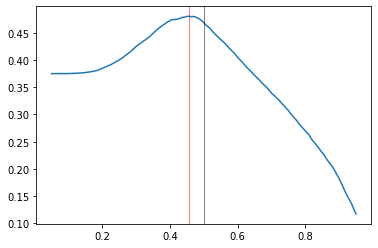

CPU times: user 20.6 s, sys: 441 ms, total: 21.1 s
Wall time: 20.9 s


In [7]:
%%time
S = np.linspace(0.05, 0.95, 150)
plt.plot(S, f3_LR_v(S))
plt.axvline(x=0.5, color='black', linewidth=0.5)
plt.axvline(x=s_opt_LR, color='red', linewidth=0.5)
plt.show()

# Forêts aléatoires

In [8]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
datasets_df = datasets(df, columns_quant=F_COLUMNS_QUANT, columns_cat=F_COLUMNS_CAT, verbose=False)
X = datasets_df['X']
y = datasets_df['y']
X_train_F, X_val_F, y_train_F, y_val_F = train_test_split(X, y, train_size=0.80, random_state=1234)

In [9]:
%%time
clf = RandomForestClassifier(**F_PARAMS, n_jobs=-1)
clf.fit(X_train_F, y_train_F)

y_probas_F = clf.predict_proba(X_val_F)[:, 1]

CPU times: user 1h 21min 6s, sys: 43.2 s, total: 1h 21min 49s
Wall time: 11min 43s


In [10]:
def f3_F(seuil):
    y_pred = (y_probas_F >= seuil) * 1
    precision = precision_score(y_val_F, y_pred)
    recall = recall_score(y_val_F, y_pred)
    f3 = (10 * precision * recall) / (9 * precision + recall)
    return f3

f3_F_v = np.vectorize(f3_F)

In [11]:
[s_opt_F] = scipy.optimize.fmin(lambda s: - f3_F(s), 0.5)
print(f"Meilleur seuil : {s_opt_F}")

Optimization terminated successfully.
         Current function value: -0.534967
         Iterations: 13
         Function evaluations: 26
Meilleur seuil : 0.5997070312500004


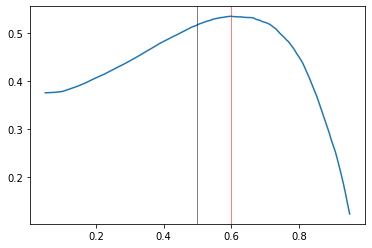

CPU times: user 21.7 s, sys: 408 ms, total: 22.1 s
Wall time: 21.9 s


In [12]:
%%time
S = np.linspace(0.05, 0.95, 150)
plt.plot(S, f3_F_v(S))
plt.axvline(x=0.5, color='black', linewidth=0.5)
plt.axvline(x=s_opt_F, color='red', linewidth=0.5)
plt.show()

# XGBoost

In [13]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
datasets_df = datasets(df, columns_quant=XG_COLUMNS_QUANT, columns_cat=XG_COLUMNS_CAT, verbose=False)
X = datasets_df['X']
y = datasets_df['y']
X_train_XG, X_val_XG, y_train_XG, y_val_XG = train_test_split(X, y, train_size=0.80, random_state=1234)

In [14]:
%%time
clf = XGBClassifier(**XG_PARAMS, booster='gbtree', objective='binary:logistic', use_label_encoder=False, n_jobs=-1)
clf.fit(X_train_XG, y_train_XG)

y_probas_XG = clf.predict_proba(X_val_XG)[:, 1]

[02:56:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2min 35s, sys: 3.63 s, total: 2min 38s
Wall time: 21.9 s


In [15]:
def f3_XG(seuil):
    y_pred = (y_probas_XG >= seuil) * 1
    precision = precision_score(y_val_XG, y_pred)
    recall = recall_score(y_val_XG, y_pred)
    f3 = (10 * precision * recall) / (9 * precision + recall)
    return f3

f3_XG_v = np.vectorize(f3_XG)

In [16]:
[s_opt_XG] = scipy.optimize.fmin(lambda s: - f3_XG(s), 0.5)
print(f"Meilleur seuil : {s_opt_XG}")

Optimization terminated successfully.
         Current function value: -0.541152
         Iterations: 11
         Function evaluations: 23
Meilleur seuil : 0.46718749999999987


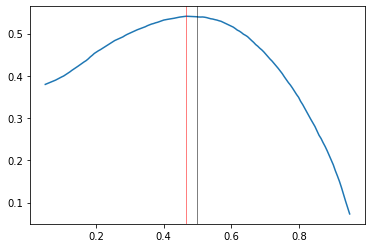

CPU times: user 22.1 s, sys: 482 ms, total: 22.5 s
Wall time: 22.6 s


In [17]:
%%time
S = np.linspace(0.05, 0.95, 150)
plt.plot(S, f3_XG_v(S))
plt.axvline(x=0.5, color='black', linewidth=0.5)
plt.axvline(x=s_opt_XG, color='red', linewidth=0.5)
plt.show()

# Sauvegarde des résultats

In [18]:
with open('backups/THRESHOLD.json', 'w') as outfile:
    json.dump({'LR': s_opt_LR, 'Forest': s_opt_F, 'XGBoost': s_opt_XG}, outfile)

In [19]:
print(f"Durée totale d'exécution : {time.strftime('%H:%M:%S', time.gmtime(time.time() - t_debut))}")

Durée totale d'exécution : 00:14:18
